In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from turboflow.models.phyrff import plDivFreeRFFNet

path_to_best_model = '/home/dicarlo_d/Documents/Code/TurboSuperResultion/.torch_checkpoints/'
best_model_ckpt = 'Turb2D-kMFN-1x32x32_freq-epoch=99-val_loss=0.00-v2.ckpt'
path_to_best_model = path_to_best_model + best_model_ckpt
model = plDivFreeRFFNet.load_from_checkpoint(path_to_best_model)

2022-03-30 19:48:21.585675: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


tensor([0.])
torch.Size([1024, 3])
tensor([[-0.1522,  0.2527],
        [-0.1016,  0.2520],
        [ 0.0946,  0.1720],
        ...,
        [ 0.0059,  0.0769],
        [ 0.0041,  0.0300],
        [ 0.0063,  0.0056]], grad_fn=<SelectBackward>)


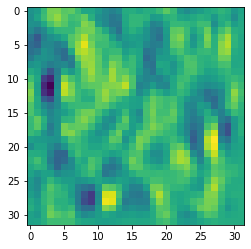

In [4]:
R = 32
t = torch.linspace(0, 0.1, 1)
print(t)
x = torch.linspace(0, 1, R)
y = torch.linspace(0, 1, R)

X = torch.stack(torch.meshgrid(t, x, y))
X = torch.flatten(X, start_dim=1)
X = X.T
print(X.shape)
y = model(X)[0]

print(y)

plt.imshow(y.reshape(R,R,2)[:,:,0].detach().numpy())

In [5]:
feats = {} #an empty dictionary
def hook_func(m , inp ,op):
   feats['feat'] = op.detach()

torch.Size([1024, 2])


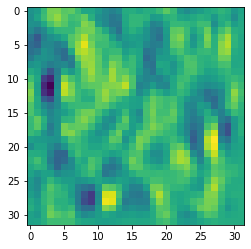

In [6]:
model.mfn.register_forward_hook(hook_func)
y = model(X)[0]
print(y.shape)

plt.imshow(y.reshape(R,R,2)[:,:,0].detach().numpy())

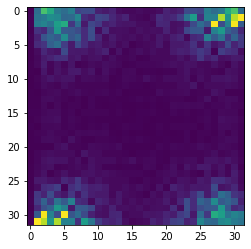

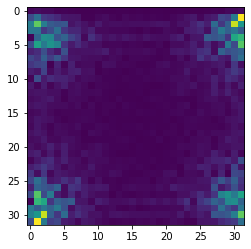

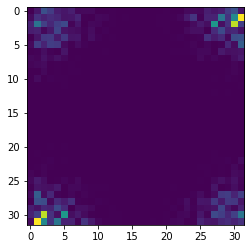

In [7]:
uv = y.reshape(R,R,2)

Ek_u = torch.abs(torch.fft.fft2(uv[:,:,0])).float()
Ek_v = torch.abs(torch.fft.fft2(uv[:,:,1])).float()

plt.imshow(Ek_u.detach().numpy())
plt.show()
plt.imshow(Ek_v.detach().numpy())
plt.show()
Ek = 0.5 * (Ek_u**2 + Ek_v**2)
# Ek = torch.fft.fftshift(Ek)

plt.imshow(Ek.detach().numpy())
plt.show()

torch.Size([1024, 65536])
torch.Size([1024, 65536])


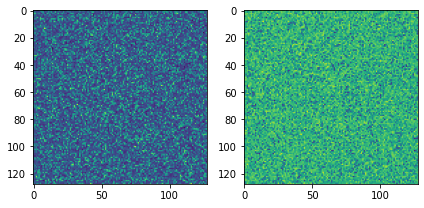

In [12]:
res = model.ifft.F
B = X.shape[0]
print(feats['feat'].shape)
feat = feats['feat']
print(feat.shape)

f = feat.reshape(B, 2, res, res, 2) # B, Dim, nrfft_x, nrfft_y, RealImag
f = torch.view_as_complex(f)

for i in range(0,res,16):
    plt.subplot(121)
    plt.imshow(torch.abs(f[i, 0, :, :]))
    plt.subplot(122)
    plt.imshow(torch.abs(f[i, 1, :, :]))
    plt.tight_layout()
    plt.show()
    break

torch.Size([1024, 2, 16384])
torch.Size([1024, 2])


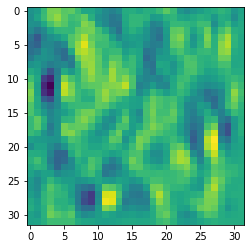

In [32]:
k = model.ifft.k
x = X[:,1:]
norm = x @ k # X x K
pi = 3.14159265359
D = torch.exp(1j*2*pi*norm / model.ifft.F)
f = feat.reshape(B, 2, res*res, 2) # B, Dim, nrfft_x, nrfft_y, RealImag
f = torch.view_as_complex(f)
print(f.shape)
u = (torch.mean(f[:,:,:1] * D[:,None,:1], dim=-1)).real
print(u.shape)
u = u.reshape(R, R, 2)
plt.imshow(u[:,:,0].detach().numpy())

In [ ]:
uv_freq = f[...,0] * torch.exp(1j*f[...,1]) # X x 2 x KK
print(uv_freq.shape)

UV = torch.mean(uv_freq, dim=0)
UV = torch.abs(UV)
print(UV.shape)
plt.imshow(UV[0].detach().numpy())

In [ ]:
pi = 3.14159265359
B, D = X.shape
freqs = model.ifft.freqs
norm = X[:,1:] @ freqs
norm = norm.reshape(B, res, res)
for i in range(0,B,1000):
    plt.imshow(uv_freq[i] * torch.sin(2*pi*norm[i]).detach().numpy())
    plt.show()

In [ ]:
f = uv_freq
f = torch.view_as_complex(f)
u = torch.mean(f * torch.exp(1j*2*pi*norm)[:,None,...], dim=[-1,-2])
u = u.real
plt.imshow(u.reshape(R,R,2)[:,:,0].detach().numpy())
plt.show()

plt.imshow(y.reshape(R,R,2)[:,:,0].detach().numpy())
plt.show()

In [ ]:
Ek = torch.norm(uv_freq, dim=-1)**2 # abs val of complex number [B,2,res,res]
Ek = torch.mean(Ek, dim=1)    # mean over dimension (U,V) [B,res,res]
# Ek = torch.flatten(Ek, start_dim=1)
print(Ek.shape)

plt.imshow(torch.mean(Ek, 0))

In [ ]:
freqs = model.freq.freqs.reshape(2, res, res) # digital frequencies [2,res,res]
k = torch.norm(freqs, dim=0)
rad = res*k
print(norm_k)
bins = torch.arange(1,res)
print(bins)

In [ ]:
inds = torch.searchsorted(bins, rad.flatten().unsqueeze(0)).squeeze().int()
print(inds)
print(inds.shape)
spec = torch.zeros([B,res])
Ek = Ek.flatten(1)
for i in inds:
    spec[:,i] += Ek[:,inds[i]]

In [ ]:
bincount = torch.bincount(inds)
binloc = torch.cumsum(bincount, dim=0).long()-1
plt.plot(binloc)
plt.show()

plt.loglog(spec.mean(0) / binloc)

In [ ]:
freqs = model.freq.freqs.reshape(2, res, res) # digital frequencies [2,res,res]
rad = torch.norm(freqs, dim=0)
rad = res * rad / torch.max(rad)
plt.imshow(rad)
plt.colorbar()

In [ ]:
freqs = model.freq.freqs.reshape(2, res, res) # digital frequencies [2,res,res]
rad = torch.norm(freqs, dim=0)
rad = res * rad / torch.max(rad)
print(rad)

In [ ]:
k_end = res
k_bin = torch.arange(k_end) + 1
bins = torch.zeros(k_end)
bins[1:] = (k_bin[1:]+k_bin[:-1])/2
bins[-1] = k_bin[-1]
bins = bins.unsqueeze(0)
bins[1:] += 1e-4
print(bins)
print(bins.shape)

In [ ]:
inds = torch.searchsorted(bins, rad.flatten().unsqueeze(0)).squeeze().int()
print(inds)
print(inds.shape)
bincount = torch.bincount(inds)
print(bincount)
print(bincount.shape)

In [ ]:
asort = torch.argsort(inds.squeeze())
print(asort)
sorted_e_ = Ek.view(Ek.shape[0], -1)[:, asort]

plt.plot(sorted_e_[0,:])
plt.show()

csum_e_ = torch.cumsum(sorted_e_, dim=1)
plt.plot(csum_e_[0,:])
plt.show()

binloc = torch.cumsum(bincount, dim=0).long()-1
plt.plot(binloc)
plt.show()

spec_ = csum_e_[:,binloc[1:]] - csum_e_[:,binloc[:-1]]
spec_ = spec_[:, :-1]
spec_ = spec_ * 2 * 3.14 * (k_bin[1:-1].float()**2) / bincount[1:-1].float()

In [ ]:
print(spec_.shape)
print(k_bin.shape)
plt.loglog(k_bin[1:-1], spec_.mean(0))

In [ ]:
plt.imshow(y[:,0].reshape(128,128).detach())

In [ ]:
from turboflow.utils import phy_utils as phy

Ek, k = phy.energy_spectrum(y.reshape(128,128,2).permute(2,0,1))
plt.loglog(k, Ek.detach())
plt.loglog(k_bin, spec_)